In [1]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
import zipfile
import io
import pandas as pd
import math
from IPython.display import display
from collections import defaultdict

zipped_data_path = "../data/clean_data/class-competition-cleaned.zip"

dataframes = defaultdict(pd.DataFrame)
with zipfile.ZipFile(zipped_data_path, "r") as zipf:
    for filename in zipf.namelist():
        if filename.endswith(".csv"):
            with zipf.open(filename) as f:
                dataframes.update({ filename : pd.read_csv(io.TextIOWrapper(f)) })

                # Lets take a look at the files
                print(f"FILE: {filename}")
                # If you want to see file info uncomment this:
                # display(dataframes[filename].info())
                # display(dataframes[filename].head())

FILE: train_call_type_A.csv
FILE: train_call_type_B.csv
FILE: train_call_type_C.csv
FILE: test_public.csv


In [2]:
train_data_A = dataframes["train_call_type_A.csv"]
train_data_B = dataframes["train_call_type_B.csv"]
train_data_C = dataframes["train_call_type_C.csv"]
test_data  = dataframes["test_public.csv"]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
from sklearn.preprocessing import StandardScaler

# Split the START_LOCATION into two new columns for latitude and longitude for train set
for i, j in train_data_B['START_LOCATION'].items():
    split = j.split(',')
    train_data_B.at[i, 'START_LAT'] = split[0]
    train_data_B.at[i, 'START_LONG'] = split[1]

# Use only data points with CALL_TYPE B
# Split the START_LOCATION into two new columns for latitude and longitude for test set
for i, j in test_data['START_LOCATION'].items():
    if not isinstance(j, str):
        test_data.at[i, 'START_LAT'] = 41.1564349 # MEAN
        test_data.at[i, 'START_LONG'] = -8.61451627 # MEAN
    else:
        split = j.split(',')
        test_data.at[i, 'START_LAT'] = split[0]
        test_data.at[i, 'START_LONG'] = split[1]

latitude_train = pd.DataFrame(train_data_B['START_LAT'].astype(float))
longitude_train = pd.DataFrame(train_data_B['START_LONG'].astype(float))
latitude_test = pd.DataFrame(test_data['START_LAT'].astype(float))
longitude_test = pd.DataFrame(test_data['START_LONG'].astype(float))

lat_scaler = StandardScaler()
lat_scaler.fit(latitude_train)

normalized_latitude_train = lat_scaler.transform(latitude_train)
normalized_latitude_test = lat_scaler.transform(latitude_test)

long_scaler = StandardScaler()
long_scaler.fit(longitude_train)

normalized_longitude_train = long_scaler.transform(longitude_train)
normalized_longitude_test = long_scaler.transform(longitude_test)

train_data_B.loc[:, 'START_LAT_NORMALIZED'] = normalized_latitude_train
train_data_B.loc[:, 'START_LONG_NORMALIZED'] = normalized_longitude_train
test_data.loc[:, 'START_LAT_NORMALIZED'] = normalized_latitude_test
test_data.loc[:, 'START_LONG_NORMALIZED'] = normalized_longitude_test

In [4]:
merged_df = pd.merge(train_data_A.drop('START_LOCATION', axis=1), train_data_B, how='outer')
merged_df = pd.merge(merged_df, train_data_C.drop('START_LOCATION', axis=1), how='outer')

merged_df['START_LONG_NORMALIZED'].fillna(train_data_B['START_LONG_NORMALIZED'].mean(), inplace=True)
merged_df['START_LAT_NORMALIZED'].fillna(train_data_B['START_LAT_NORMALIZED'].mean(), inplace=True)

In [5]:
from sklearn.preprocessing import LabelEncoder

def encode(col, train, test):
	labelEncoder = LabelEncoder()

	train_vals, test_vals = train[col].copy(), test[col].copy()
	train_vals[np.isnan(train_vals)], test_vals[np.isnan(test_vals)] = 0, 0
	merge = pd.concat([train_vals, test_vals])

	labelEncoder.fit(merge)
	
	train[col + "_ENCODED"] = labelEncoder.transform(train_vals)
	test[col + "_ENCODED"] = labelEncoder.transform(test_vals)
	return labelEncoder

taxi_id_encoder = encode('TAXI_ID', merged_df, test_data)
origin_call_encoder = encode('ORIGIN_CALL', merged_df, test_data)
origin_stand_encoder = encode('ORIGIN_STAND', merged_df, test_data)

In [6]:
from sklearn.model_selection import train_test_split

# We could totally change this. Utilization of these just probably requires further preprocessing.
ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION = ['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'POLYLINE', 'START_LOCATION', 'TAXI_ID', 'START_LAT', 'START_LONG', 'START_LAT_NORMALIZED', 'START_LONG_NORMALIZED']

X = merged_df.drop("TRAVEL_TIME", axis=1)
X = X.loc[:, ~X.columns.isin(ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION)]
y = merged_df["TRAVEL_TIME"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

test_features = test_data.loc[:, ~test_data.columns.isin(ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION)]

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534075 entries, 0 to 1534074
Data columns (total 14 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   MON_sin               1534075 non-null  float64
 1   MON_cos               1534075 non-null  float64
 2   DAY_sin               1534075 non-null  float64
 3   DAY_cos               1534075 non-null  float64
 4   HR_sin                1534075 non-null  float64
 5   HR_cos                1534075 non-null  float64
 6   MIN_sin               1534075 non-null  float64
 7   MIN_cos               1534075 non-null  float64
 8   WK_sin                1534075 non-null  float64
 9   WK_cos                1534075 non-null  float64
 10  YR_2013               1534075 non-null  bool   
 11  TAXI_ID_ENCODED       1534075 non-null  int64  
 12  ORIGIN_CALL_ENCODED   1534075 non-null  int64  
 13  ORIGIN_STAND_ENCODED  1534075 non-null  int64  
dtypes: bool(1), float64(10), int64(3)


In [12]:
from torch.utils.data import DataLoader, Dataset
from mlp_utils import TaxiDataset

# Separate the boolean columns
boolean_cols = ['YR_2013']

# Separate the float columns
float_cols = ['MON_sin', 'MON_cos', 'DAY_sin', 'DAY_cos', 'HR_sin', 'HR_cos',
              'MIN_sin', 'MIN_cos', 'WK_sin', 'WK_cos']

# Separate the encoded columns
encoded_cols = ['TAXI_ID_ENCODED', 'ORIGIN_CALL_ENCODED', 'ORIGIN_STAND_ENCODED']

# Boolean columns
train_boolean_data = X_train[boolean_cols].astype(int).values
test_boolean_data = X_test[boolean_cols].astype(int).values
test_public_boolean_data = test_features[boolean_cols].astype(int).values

# Float columns
train_float_data = X_train[float_cols].astype(float).values
test_float_data = X_test[float_cols].astype(int).values
test_public_float_data = test_features[float_cols].astype(int).values

# Encoded columns
train_encoded_data = X_train[encoded_cols].astype(int).values
test_encoded_data = X_test[encoded_cols].astype(int).values
test_public_encoded_data = test_features[encoded_cols].astype(int).values

train_concat = np.concatenate((train_boolean_data, train_float_data, train_encoded_data), axis=1)
test_concat = np.concatenate((test_boolean_data, test_float_data, test_encoded_data), axis=1)
test_public_concat = np.concatenate((test_public_boolean_data, test_public_float_data, test_public_encoded_data), axis=1)

X_train_tensor = torch.tensor(train_concat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32)
X_test_tensor = torch.tensor(test_concat, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)
X_test_public_tensor = torch.tensor(test_public_concat, dtype=torch.float32)

train_dataset = TaxiDataset(X_train_tensor, y_train_tensor)
test_dataset = TaxiDataset(X_test_tensor, y_test_tensor)
test_public_dataset = TaxiDataset(X_test_public_tensor)

batch_size = 64

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dataloader_pred = DataLoader(test_public_dataset, batch_size=batch_size)

In [15]:
import torch.nn.functional as F

def init_weights(m):
  if isinstance(m, nn.Linear):
    nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)

class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.embed_taxi_id = nn.Embedding(len(taxi_id_encoder.classes_), 8)
    self.embed_origin_call = nn.Embedding(len(origin_call_encoder.classes_), 8)
    self.embed_origin_stand = nn.Embedding(len(origin_stand_encoder.classes_), 8)
    self.dropout1 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(35, 128)
    self.dropout2 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(128, 64)
    self.dropout3 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(64, 32)
    self.dropout4 = nn.Dropout(0.5)
    self.fc4 = nn.Linear(32, 16)
    self.fc5 = nn.Linear(16, 1)
    self.apply(init_weights)
    self.apply(init_weights)

  def forward(self, x):
    '''
      Forward pass
    '''
    taxi_id = self.embed_taxi_id(x[:, -3].to(torch.int32))
    origin_call = self.embed_origin_call(x[:, -2].to(torch.int32))
    origin_stand = self.embed_origin_stand(x[:, -1].to(torch.int32))
    x = torch.cat([taxi_id, origin_call, origin_stand, x[:, :-3]], axis=1).to(torch.float32)
    x = self.dropout1(x)
    x = F.relu(self.fc1(x))
    x = self.dropout2(x)
    x = F.relu(self.fc2(x))
    x = self.dropout3(x)
    x = F.relu(self.fc3(x))
    x = self.dropout4(x)
    x = F.relu(self.fc4(x))
    x = self.fc5(x)
    return x

In [16]:
from mlp_utils import num_parameters

mlp = MLP()
if torch.cuda.is_available():
    mlp.cuda()
 
num_parameters(mlp)

465657

In [17]:
from mlp_utils import pipeline
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.0001, weight_decay=1e-5)

train_losses, test_loss, predictions = pipeline(mlp, optimizer, dataloader_train=dataloader_train, 
                                                dataloader_test=dataloader_test, dataloader_pred=dataloader_pred,
                        			device=device, criterion=criterion, epochs=50, verbose=True)

  2%|▏         | 1/50 [01:11<58:40, 71.84s/it]

Epoch 1 - Train Loss = 440.34154382757225


  4%|▍         | 2/50 [02:21<56:27, 70.56s/it]

Epoch 2 - Train Loss = 419.30737722930957


  6%|▌         | 3/50 [03:33<55:52, 71.34s/it]

Epoch 3 - Train Loss = 415.1978160833783


  8%|▊         | 4/50 [04:44<54:31, 71.12s/it]

Epoch 4 - Train Loss = 411.70951025438274


 10%|█         | 5/50 [05:54<52:56, 70.59s/it]

Epoch 5 - Train Loss = 408.68062602681096


 12%|█▏        | 6/50 [07:04<51:39, 70.44s/it]

Epoch 6 - Train Loss = 406.4778358347046


 14%|█▍        | 7/50 [08:14<50:21, 70.27s/it]

Epoch 7 - Train Loss = 404.32781281573904


 16%|█▌        | 8/50 [09:22<48:44, 69.64s/it]

Epoch 8 - Train Loss = 402.3452537063167


 18%|█▊        | 9/50 [10:30<47:16, 69.17s/it]

Epoch 9 - Train Loss = 400.85123047354205


 20%|██        | 10/50 [11:39<45:59, 68.99s/it]

Epoch 10 - Train Loss = 399.4245230813827


 22%|██▏       | 11/50 [12:48<44:48, 68.93s/it]

Epoch 11 - Train Loss = 398.2910403736074


 24%|██▍       | 12/50 [13:56<43:32, 68.76s/it]

Epoch 12 - Train Loss = 397.39241214500606


 26%|██▌       | 13/50 [15:04<42:19, 68.63s/it]

Epoch 13 - Train Loss = 396.6839479878521


 28%|██▊       | 14/50 [16:12<41:04, 68.47s/it]

Epoch 14 - Train Loss = 396.04690070740133


 30%|███       | 15/50 [17:21<39:54, 68.40s/it]

Epoch 15 - Train Loss = 395.41456058160804


 32%|███▏      | 16/50 [18:30<39:00, 68.84s/it]

Epoch 16 - Train Loss = 394.6685107526272


 34%|███▍      | 17/50 [19:39<37:50, 68.80s/it]

Epoch 17 - Train Loss = 393.83832295839693


 36%|███▌      | 18/50 [20:48<36:37, 68.67s/it]

Epoch 18 - Train Loss = 393.0782632692386


 38%|███▊      | 19/50 [21:56<35:26, 68.58s/it]

Epoch 19 - Train Loss = 392.64392157181067


 40%|████      | 20/50 [23:06<34:35, 69.18s/it]

Epoch 20 - Train Loss = 392.14292040667016


 42%|████▏     | 21/50 [24:18<33:45, 69.85s/it]

Epoch 21 - Train Loss = 391.624163207209


 44%|████▍     | 22/50 [25:28<32:37, 69.90s/it]

Epoch 22 - Train Loss = 391.08526264190493


 46%|████▌     | 23/50 [26:39<31:33, 70.13s/it]

Epoch 23 - Train Loss = 390.64107177226265


 48%|████▊     | 24/50 [27:49<30:25, 70.21s/it]

Epoch 24 - Train Loss = 390.2359526981823


 50%|█████     | 25/50 [28:59<29:10, 70.01s/it]

Epoch 25 - Train Loss = 389.82583302532913


 52%|█████▏    | 26/50 [30:08<27:53, 69.73s/it]

Epoch 26 - Train Loss = 389.5283511062793


 54%|█████▍    | 27/50 [31:18<26:46, 69.87s/it]

Epoch 27 - Train Loss = 389.15521918336594


 56%|█████▌    | 28/50 [32:27<25:29, 69.52s/it]

Epoch 28 - Train Loss = 388.8641927963485


 58%|█████▊    | 29/50 [33:37<24:27, 69.90s/it]

Epoch 29 - Train Loss = 388.5747411176136


 60%|██████    | 30/50 [34:49<23:26, 70.35s/it]

Epoch 30 - Train Loss = 388.2029781551633


 62%|██████▏   | 31/50 [35:59<22:18, 70.45s/it]

Epoch 31 - Train Loss = 388.0757040397887


 64%|██████▍   | 32/50 [37:08<21:00, 70.00s/it]

Epoch 32 - Train Loss = 387.79633074830303


 66%|██████▌   | 33/50 [38:17<19:45, 69.73s/it]

Epoch 33 - Train Loss = 387.61955884886527


 68%|██████▊   | 34/50 [39:26<18:31, 69.45s/it]

Epoch 34 - Train Loss = 387.3431167241918


 70%|███████   | 35/50 [40:35<17:19, 69.31s/it]

Epoch 35 - Train Loss = 387.1772101326315


 72%|███████▏  | 36/50 [41:44<16:10, 69.30s/it]

Epoch 36 - Train Loss = 386.9568552929531


 74%|███████▍  | 37/50 [42:54<15:02, 69.39s/it]

Epoch 37 - Train Loss = 386.79608315497455


 76%|███████▌  | 38/50 [44:03<13:52, 69.36s/it]

Epoch 38 - Train Loss = 386.5766688705089


 78%|███████▊  | 39/50 [45:13<12:42, 69.33s/it]

Epoch 39 - Train Loss = 386.50576504313483


 80%|████████  | 40/50 [46:22<11:33, 69.35s/it]

Epoch 40 - Train Loss = 386.1896218780267


 82%|████████▏ | 41/50 [47:32<10:25, 69.45s/it]

Epoch 41 - Train Loss = 386.04130596111287


 84%|████████▍ | 42/50 [48:41<09:15, 69.42s/it]

Epoch 42 - Train Loss = 385.91994388094764


 86%|████████▌ | 43/50 [49:50<08:05, 69.40s/it]

Epoch 43 - Train Loss = 385.78507953752916


 88%|████████▊ | 44/50 [51:00<06:56, 69.47s/it]

Epoch 44 - Train Loss = 385.56188592222287


 90%|█████████ | 45/50 [52:09<05:45, 69.18s/it]

Epoch 45 - Train Loss = 385.52706465838935


 92%|█████████▏| 46/50 [53:18<04:36, 69.13s/it]

Epoch 46 - Train Loss = 385.24396676980695


 94%|█████████▍| 47/50 [54:26<03:27, 69.06s/it]

Epoch 47 - Train Loss = 385.1366468437584


 96%|█████████▌| 48/50 [55:35<02:18, 69.03s/it]

Epoch 48 - Train Loss = 384.9555208932195


 98%|█████████▊| 49/50 [56:45<01:09, 69.13s/it]

Epoch 49 - Train Loss = 384.907046483179


100%|██████████| 50/50 [57:54<00:00, 69.49s/it]

Epoch 50 - Train Loss = 384.82173622868385
Training process has finished.


In [18]:
print(f"Final Train Loss: {train_losses[-1]}")
print(f"Test Loss: {test_loss}")

Final Train Loss: 384.82173622868385
Test Loss: 387.7429011128003


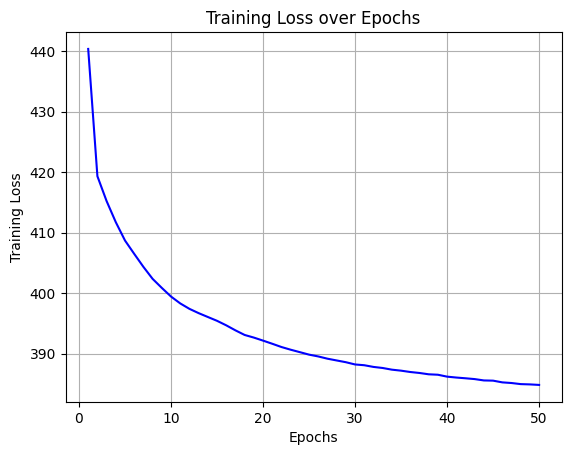

[440.34154382757225, 419.30737722930957, 415.1978160833783, 411.70951025438274, 408.68062602681096, 406.4778358347046, 404.32781281573904, 402.3452537063167, 400.85123047354205, 399.4245230813827, 398.2910403736074, 397.39241214500606, 396.6839479878521, 396.04690070740133, 395.41456058160804, 394.6685107526272, 393.83832295839693, 393.0782632692386, 392.64392157181067, 392.14292040667016, 391.624163207209, 391.08526264190493, 390.64107177226265, 390.2359526981823, 389.82583302532913, 389.5283511062793, 389.15521918336594, 388.8641927963485, 388.5747411176136, 388.2029781551633, 388.0757040397887, 387.79633074830303, 387.61955884886527, 387.3431167241918, 387.1772101326315, 386.9568552929531, 386.79608315497455, 386.5766688705089, 386.50576504313483, 386.1896218780267, 386.04130596111287, 385.91994388094764, 385.78507953752916, 385.56188592222287, 385.52706465838935, 385.24396676980695, 385.1366468437584, 384.9555208932195, 384.907046483179, 384.82173622868385]


In [19]:
import matplotlib.pyplot as plt

# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot the training loss
plt.plot(epochs, train_losses, 'b-')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

print(train_losses)

In [20]:
from mlp_utils import test_prediction_to_csv

test_prediction_to_csv(predictions, "mlp_encoding_layers_concatenated.csv", test_data)